In [29]:
import torch
import torch.nn as nn
from models import SEModular
from GridMLM_tokenizers import CSGridMLMTokenizer
from data_utils import CSGridMLMDataset, CSGridMLM_collate_fn
from torch.utils.data import DataLoader
from train_utils import apply_masking
from generate_utils import generate_files_with_nucleus, generate_files_with_base2, generate_files_with_random, load_SE_Modular
import matplotlib.pyplot as plt
import seaborn as sns
from plot_utils import save_attention_maps_with_split, save_attention_maps

In [30]:
nvis = None
curriculum_type, subfolder = 'base2', 'Q4_L80_bar_PC'
# curriculum_type, subfolder = 'random', 'Q4_L80_bar_PC'
# curriculum_type, subfolder = 'f2f', 'Q4_L80_bar_PC'

In [31]:
total_stages = None if curriculum_type == 'f2f' else 10
condition_dim = None if 'bar' in subfolder else 16
trainable_pos_emb = False if curriculum_type == 'f2f' else True

grid_lenght = int(subfolder.split('_L')[1].split('_')[0])

intertwine_bar_info = 'bar' in subfolder

generation_function_name = 'base2'
generation_function_name = 'random'
generation_function_name = 'nucleus'

gen_funs = {
    'base2': generate_files_with_base2,
    'random': generate_files_with_random,
    'nucleus': generate_files_with_nucleus,
}

gen_fun = gen_funs[generation_function_name]

tokenizer = CSGridMLMTokenizer(
    fixed_length=grid_lenght,
    quantization='16th' if 'Q16' in subfolder else '4th',
    intertwine_bar_info=intertwine_bar_info,
    trim_start=False,
    use_pc_roll='PC' in subfolder,
    use_full_range_melody='FR' in subfolder
)

In [32]:
# val_dir = '/media/maindisk/data/hooktheory_midi_hr/CA_test'
# val_dir = '/media/maindisk/data/hooktheory_midi_hr/CA_test'
val_dir = '/media/maindisk/data/synthetic_CA_test'

In [33]:
# curriculum_type = 'f2f'

# exponent, nvis = 5, None
# exponent, nvis = 5, 0
# exponent, nvis = 5, 5
# exponent, nvis = 5, 15
# exponent, nvis = 5, 31
# exponent, nvis = 5, 51

# exponent, nvis = 7, None
# exponent, nvis = 7, 0
# exponent, nvis = 7, 5
# exponent, nvis = 7, 15
# exponent, nvis = 7, 31
# exponent, nvis = 7, 51

# exponent, nvis = 10, None
# exponent, nvis = 10, 0
# exponent, nvis = 10, 5
# exponent, nvis = 10, 15
# exponent, nvis = 10, 31
# exponent, nvis = 10, 50

unmasking_order = 'start' # in ['random', 'start', 'end', 'certain', 'uncertain']

# subfolder = 'SE/CA'
# subfolder = 'SE/all12'
# device_name = 'cuda:2'
device_name = 'cpu'
model = load_SE_Modular(
    d_model=512, 
    nhead=8, 
    num_layers=8,
    curriculum_type=curriculum_type,
    subfolder='art_' + subfolder,
    device_name=device_name,
    tokenizer=tokenizer,
    grid_length=grid_lenght,
    condition_dim=condition_dim,  # if not None, add a condition token of this dim at start
    unmasking_stages=total_stages,  # if not None, use stage-based unmasking
    trainable_pos_emb=trainable_pos_emb,
    nvis=nvis
)

model_path:  saved_models/SE/art_Q4_L80_bar_PC/base2.pt


In [34]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(count_parameters(model))

25970147


In [35]:
import os
data_files = []
for dirpath, _, filenames in os.walk(val_dir):
    for file in filenames:
        if file.endswith('.xml') or file.endswith('.mxl') or file.endswith('.musicxml') \
            or file.endswith('.mid') or file.endswith('.midi'):
            full_path = os.path.join(dirpath, file)
            data_files.append(full_path)
print(len(data_files))

100


In [36]:
val_idx = 0

input_f = data_files[val_idx]
# input_f = 'example_inputs/test_midi_constraints.mid'

midi_folder = 'examples_MIDI/art_' + subfolder + '_' + generation_function_name + '/' + curriculum_type
if nvis is not None:
    midi_folder += '_nvis' + str(nvis)
midi_folder += '_' + unmasking_order + '/'
os.makedirs(midi_folder, exist_ok=True)

gen_harm, real_harm, gen_score, real_score = gen_fun(
        model=model,
        tokenizer=tokenizer,
        input_f=input_f,
        mxl_folder=None,
        midi_folder=midi_folder,
        name_suffix='art_' + subfolder,
        use_constraints=False,
        intertwine_bar_info=intertwine_bar_info,
        normalize_tonality=False,
        temperature=1.0,
        p=0.9,
        unmasking_order=unmasking_order,
        num_stages=10,
        use_conditions=curriculum_type!='f2f',
        create_gen=True,
        create_real=False
    )

# gen_harm, real_harm, gen_score, real_score, avg_diffs = generate_files_with_greedy(
# gen_harm, real_harm, gen_score, real_score, avg_diffs = generate_files_with_beam(
# if curriculum_type == 'f2f':
#     gen_harm, real_harm, gen_score, real_score = generate_files_with_nucleus(
#         model=model,
#         tokenizer=tokenizer,
#         input_f=input_f,
#         mxl_folder=None,
#         midi_folder=midi_folder,
#         name_suffix=curriculum_type,
#         intertwine_bar_info=intertwine_bar_info,
#         normalize_tonality=False,
#         use_constraints=False,
#         temperature=1.0,
#         # beam_size=5,
#         # top_k=50,
#         p=0.9,
#         unmasking_order=unmasking_order, # in ['random', 'start', 'end', 'certain', 'uncertain']
#         create_gen=True,
#         create_real=True
#     )
# elif curriculum_type == 'base2':
#     gen_harm, real_harm, gen_score, real_score = generate_files_with_base2(
#         model=model,
#         tokenizer=tokenizer,
#         input_f=input_f,
#         mxl_folder=None,
#         midi_folder=midi_folder,
#         name_suffix=subfolder,
#         use_constraints=False,
#         normalize_tonality=False,
#         num_stages=10,
#         temperature=1.0,
#         create_gen=True,
#         create_real=False
#     )
# elif curriculum_type == 'random':
#     gen_harm, real_harm, gen_score, real_score = generate_files_with_random(
    #     model=model,
    #     tokenizer=tokenizer,
    #     input_f=input_f,
    #     mxl_folder=None,
    #     midi_folder=midi_folder,
    #     name_suffix=subfolder,
    #     use_constraints=False,
    #     normalize_tonality=False,
    #     num_stages=10,
    #     temperature=1.0,
    #     create_gen=True,
    #     create_real=False
    # )

In [37]:
tokenizer.ids_to_tokens[269]

'A:min'

In [38]:
# plt.plot(avg_diffs)

In [39]:
harm_string = '_'.join( gen_harm )
# print(gen_harm)
if '<bar>' in harm_string:
    harm_bars = harm_string.split( '<bar>_' )
    for h in harm_bars:
        print(h)
else:
    for i, h in enumerate(gen_harm):
        if i%(grid_lenght/16) == 0 and i > 0:
            print('')
        print(h + '_', end='')













A:min_
C:maj_


A:min_C:maj_
F:maj_D:min_F:maj_C:maj_
F:maj_C:maj_C:maj_A:min_
A:min_A:min_F:maj_D:min_
F:maj_A:min_A:min_F:maj_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>


In [40]:
harm_string = '_'.join( real_harm )
# print(gen_harm)
if '<bar>' in harm_string:
    harm_bars = harm_string.split( '<bar>_' )
    for h in harm_bars:
        print(h)
else:
    for i, h in enumerate(real_harm):
        if i%(grid_lenght/16) == 0 and i > 0:
            print('')
        print(h + '_', end='')


F:maj_A:min_C:maj_B:dim_
E:min_C:maj_B:dim_D:min_
E:min_D:min_E:min_E:min_
A:min_D:min_B:dim_D:min_
D:min_B:dim_D:min_C:maj_
C:maj_D:min_F:maj_C:maj_
C:maj_F:maj_B:dim_A:min_
B:dim_D:min_D:min_A:min_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>_<pad>


<Axes: >

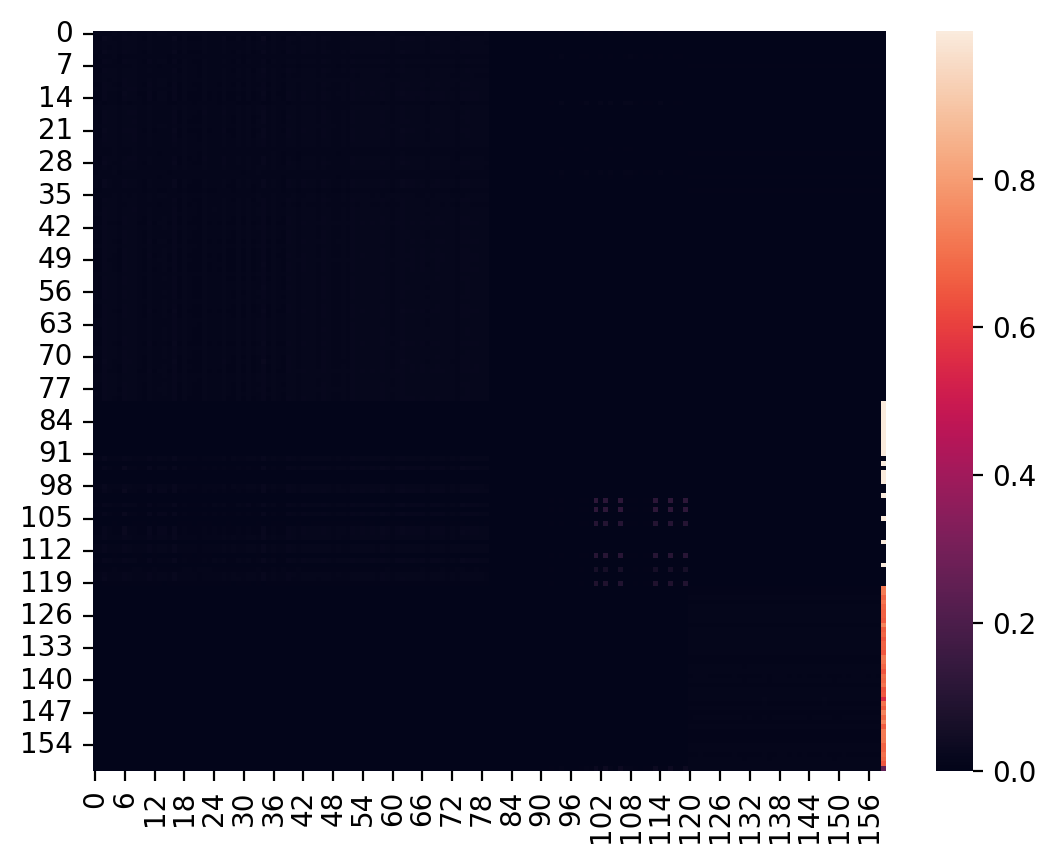

In [41]:
# After running a forward pass with attention outputs enabled
# attn_maps = model.harmony_encoder.layers[4].last_attn_weights  # example shape: [B, heads, L, L]
self_attns = model.get_attention_maps()

# Focus on one item in batch, one head
map = self_attns[0][0, 0].detach().cpu().numpy()
sns.heatmap(map)

In [42]:
save_dir='figs/attn_maps/art_' + subfolder + '/' + curriculum_type
if nvis is not None:
    save_dir += '_nvis' + str(nvis)

save_attention_maps_with_split(
    self_attns,
    melody_len=grid_lenght,
    save_dir=save_dir + '/self/',
    prefix='self'
)